# Boxplots for permutations analysis (male downsampling to female level)

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Function and configuration

In [2]:
config = list(
    "Caudate"="../../../caudate/subsampling_male/deg_summary/_m/permutations.csv", 
    "DLPFC"="../../../dlpfc/subsampling_male/deg_summary/_m/permutations.csv", 
    "Hippocampus"="../../../hippocampus/subsampling_male/deg_summary/_m/permutations.csv"
)

In [3]:
save_ggplots <- function(p, fn, w=6, h=6){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}

merge_data <- function(){
    datalist = list()
    for(tissue in c("Caudate", "DLPFC", "Hippocampus")){
        df = data.table::fread(config[[tissue]])
        df$Tissue <- tissue  # maybe you want to keep track of which iteration produced it?
        datalist[[tissue]] <- df
    }
    return(bind_rows(datalist) %>% 
           select(Symbol, gencodeID, logFC, t, adj.P.Val, Permutation, Tissue))
}

get_perm_data <- function(df, tissue){
    return(df %>% group_by(Permutation, Tissue) %>% 
           summarize(Size = n()) %>% 
           replace_na(list(DLPFC = 0, Hippocampus = 0, Caudate = 0)) %>% 
           filter(`Tissue` == tissue))
}

get_female_degs <- function(tissue){
    fn = paste0("../../../", tolower(tissue), 
                "/female_analysis/_m/genes/diffExpr_szVctl_full.txt")
    return(data.table::fread(fn) %>% filter("adj.P.Val" < 0.05))
}

cal_zscore <- function(df, tissue){
    x = dim(get_female_degs(tissue))[1]
    mu = mean(get_perm_data(df, tissue)$Size)
    sigma = sd(get_perm_data(df, tissue)$Size)
    return((x - mu) / sigma)
}

## Merge dataframes

In [4]:
big_df <- merge_data()
big_df %>% head()

Symbol,gencodeID,logFC,t,adj.P.Val,Permutation,Tissue
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
GDNF-AS1,ENSG00000248587.7,0.8247287,8.000253,3.219110e-08,266,Caudate
SLC24A3,ENSG00000185052.11,0.2920501,6.148298,1.485328e-04,266,Caudate
,ENSG00000240521.1,0.9333908,5.918368,2.194000e-04,266,Caudate
KCNS2,ENSG00000156486.7,0.4139240,5.832974,2.194000e-04,266,Caudate
VWC2,ENSG00000188730.4,0.4051942,5.830198,2.194000e-04,266,Caudate
KCNH5,ENSG00000140015.19,0.4670138,5.826467,2.194000e-04,266,Caudate


## Calculate significance

In [5]:
z_scores = c(); two_tail = c(); tissues = c();
for(tissue in c("Caudate", "DLPFC", "Hippocampus")){
    tissues = c(tissues, tissue)
    ## Z-score
    q = cal_zscore(big_df, tissue); z_scores = c(z_scores, q)
    ## Convert to p-value
    two_tail = c(two_tail, 2*pnorm(q, mean=0, sd=1, lower.tail=TRUE))
}

dt = data.frame("Tissue"=tissues, "Z_score"=z_scores, "P_Value"=two_tail)
dt

`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.


Tissue,Z_score,P_Value
<fct>,<dbl>,<dbl>
Caudate,-0.7698913,0.4413644
DLPFC,-0.4617181,0.6442835
Hippocampus,-0.3906155,0.6960814


In [6]:
dt %>% data.table::fwrite("permutation_pvalues.tsv", sep='\t')

## Plot figures

In [7]:
df = big_df %>% group_by(Permutation, Tissue) %>% summarize(Size = n()) %>%
    as.data.frame %>% pivot_wider(names_from = Tissue, values_from = Size) %>%
    replace_na(list(DLPFC = 0, Hippocampus = 0, Caudate = 0)) %>% 
    pivot_longer(-Permutation, names_to="Tissue", values_to="DEGs") %>%
    mutate_if(is.character, as.factor)
df %>% head()

`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.


Permutation,Tissue,DEGs
<int>,<fct>,<int>
1,Caudate,324
1,DLPFC,1
1,Hippocampus,1
2,Caudate,38
2,DLPFC,0
2,Hippocampus,13


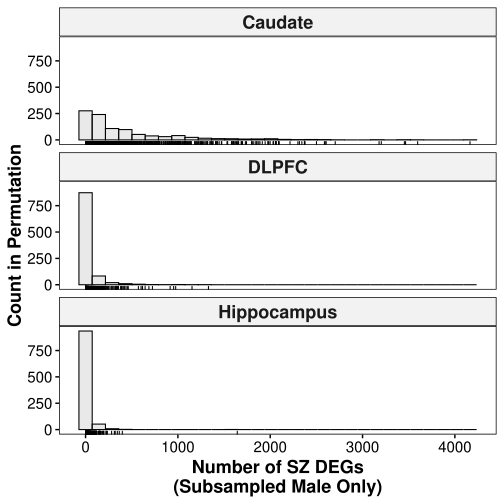

In [8]:
hist = gghistogram(df, x="DEGs", fill="lightgray", bins=30, rug=TRUE, 
                   facet.by="Tissue", ncol=1, ylab="Count in Permutation",
                   xlab="Number of SZ DEGs\n(Subsampled Male Only)",
                   panel.labs.font=list(face='bold', size=18),
                   ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
        font("xy.title", face="bold", size=18)
hist

In [9]:
save_ggplots(hist, "permutation_histogram", 6, 7)

## Permutation DEGs Summary

In [10]:
big_df %>% group_by(Permutation, Tissue) %>% summarize(Size = n()) %>%
    as.data.frame %>% pivot_wider(names_from = Tissue, values_from = Size) %>%
    replace_na(list(DLPFC = 0, Hippocampus = 0, Caudate = 0)) %>% 
    pivot_longer(-Permutation, names_to="Tissue", values_to="DEGs") %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Tissue) %>% summarize(Mean = mean(DEGs), Median = median(DEGs), Std = sd(DEGs))

`summarise()` has grouped output by 'Permutation'. You can override using the
`.groups` argument.


Tissue,Mean,Median,Std
<fct>,<dbl>,<dbl>,<dbl>
Caudate,433.23046,200.5,564.51642
DLPFC,35.94088,1.0,112.81116
Hippocampus,15.01503,0.0,65.57993


## Reproducibility Information

In [11]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2022-09-13 21:11:05 EDT"

   user  system elapsed 
  5.403   0.465  17.568 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       CentOS Linux 7 (Core)       
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       US/Eastern                  
 date     2022-09-13                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version    date       lib source                            
 abind         1.4-5      2016-07-21 [1] CRAN (R 3.6.1)                    
 assertthat    0.2.1      2019-03-21 [2] CRAN (R 3.6.1)                    
 backports     1.2.1      2020-12-09 [2] CRAN (R 3.6.1)                    
 base64enc     0.1-3      2015-07-28 [2] CRAN (R 3.6.1)            